Lets try to see if we can predict the weather in NYC using this hourly dataset.

First we have to download our data and import some packages

In [2]:
!pip install hypopt lagmat

  Created wheel for lagmat: filename=lagmat-0.2.0-cp36-none-any.whl size=7600 sha256=155a037d1575b147e9bdb5c756183569c8a6cc8b5511eb22ed42f28b9781d139
  Stored in directory: /root/.cache/pip/wheels/ee/a6/50/01a6ccd27e742cdbb5099e9dc7e16972c8685bb11f1db03911
Successfully built lagmat


In [ ]:
import datetime as dt

import geopy.distance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import xgboost as xgb
from hypopt import GridSearch
from lagmat import lagmat
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## ETL

In [ ]:
import os

os.environ["KAGGLE_USERNAME"] = "marvint"
os.environ["KAGGLE_KEY"] = "884483c701b1bc917ca8ea9a4825847d"

In [ ]:
import kaggle

kaggle.api.authenticate()
kaggle.api.dataset_download_files(
    "selfishgene/historical-hourly-weather-data", path="weather", unzip=True
)

In [ ]:
NYC = "New York"

Now lets import it all and store it in a data dictionary:

In [ ]:
data = {
    name: pd.read_csv(
        "./weather/%s.csv" % (name), index_col="datetime", parse_dates=["datetime"]
    )
    for name in [
        "humidity",
        "pressure",
        "temperature",
        "weather_description",
        "wind_direction",
        "wind_speed",
    ]
}

In [ ]:
data["city_attributes"] = pd.read_csv("./weather/city_attributes.csv", index_col="City")

## Data scrubbing and initial data exploration

Lets take a look at our data quality, do we have NaNs? Lets forward fill our NaNs so we don't accidentally use future information.

In [9]:
for name in data:
    print(name, data[name].isnull().sum().sum())
    data[name].fillna(method="ffill", inplace=True)

humidity 28651
pressure 16680
temperature 8030
weather_description 7955
wind_direction 7975
wind_speed 7993
city_attributes 0


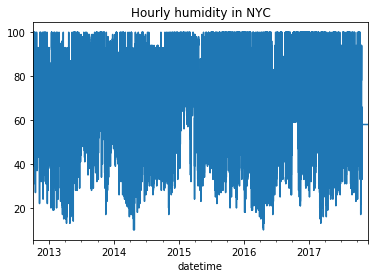

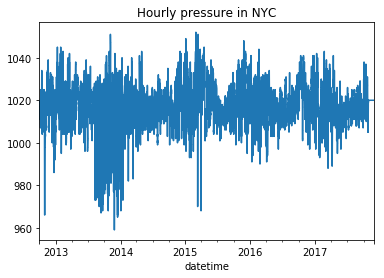

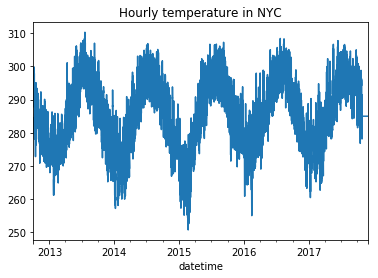

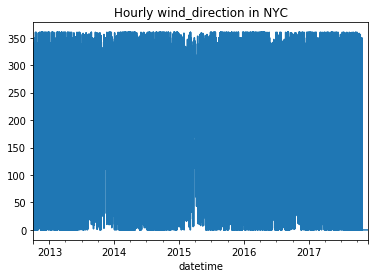

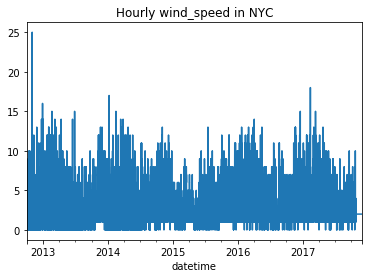

In [10]:
numerical_names = [
    "humidity",
    "pressure",
    "temperature",
    "wind_direction",
    "wind_speed",
]
for name in numerical_names:
    plt.figure()
    data[name][NYC].plot()
    plt.title("Hourly %s in NYC" % name)

It looks like the tail of our data for NYC has been forwarded filled by our data cleaning for about a month, lets figure out the last good reading for values in NYC:

In [11]:
for name in numerical_names:
    end_value = data[name][NYC].values[-1]
    mask = (data[name][NYC] == end_value).values
    mask[1:] = ~mask[:-1] & mask[1:]
    last_good_reading = data[name].index[mask][-1]
    print(name, last_good_reading)

humidity 2017-10-28 00:00:00
pressure 2017-10-27 23:00:00
temperature 2017-10-28 00:00:00
wind_direction 2017-10-28 00:00:00
wind_speed 2017-10-28 00:00:00


Lets check the head of our dataframes as well:

In [12]:
for name in numerical_names:
    print(name)
    print(data[name][NYC].head())

humidity
datetime
2012-10-01 12:00:00     NaN
2012-10-01 13:00:00    58.0
2012-10-01 14:00:00    57.0
2012-10-01 15:00:00    57.0
2012-10-01 16:00:00    57.0
Name: New York, dtype: float64
pressure
datetime
2012-10-01 12:00:00       NaN
2012-10-01 13:00:00    1012.0
2012-10-01 14:00:00    1012.0
2012-10-01 15:00:00    1012.0
2012-10-01 16:00:00    1012.0
Name: New York, dtype: float64
temperature
datetime
2012-10-01 12:00:00           NaN
2012-10-01 13:00:00    288.220000
2012-10-01 14:00:00    288.247676
2012-10-01 15:00:00    288.326940
2012-10-01 16:00:00    288.406203
Name: New York, dtype: float64
wind_direction
datetime
2012-10-01 12:00:00      NaN
2012-10-01 13:00:00    260.0
2012-10-01 14:00:00    260.0
2012-10-01 15:00:00    260.0
2012-10-01 16:00:00    260.0
Name: New York, dtype: float64
wind_speed
datetime
2012-10-01 12:00:00    NaN
2012-10-01 13:00:00    7.0
2012-10-01 14:00:00    7.0
2012-10-01 15:00:00    7.0
2012-10-01 16:00:00    7.0
Name: New York, dtype: float64


So we're going to have to drop NaNs for the leading edge of our data as well. Lets not do it here because we might want to use data from other cities.

Lets go back to data exploration of our raw data and look at it at lower sampling frequencies.

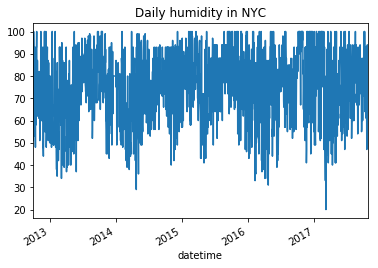

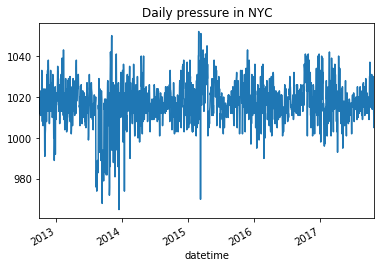

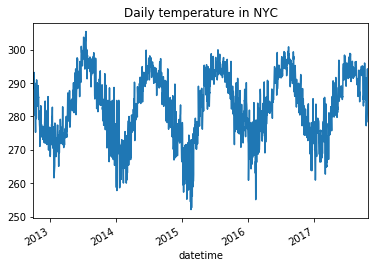

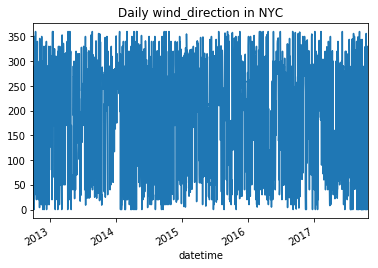

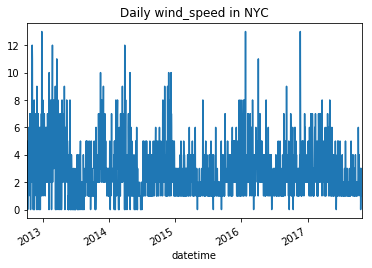

In [13]:
for name in numerical_names:
    plt.figure()
    data[name][NYC][:last_good_reading].asfreq("D").plot()
    plt.title("Daily %s in NYC" % name)

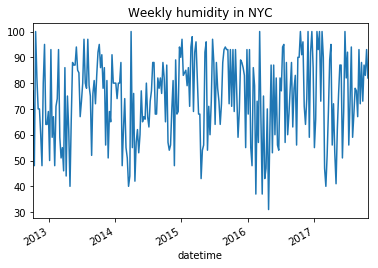

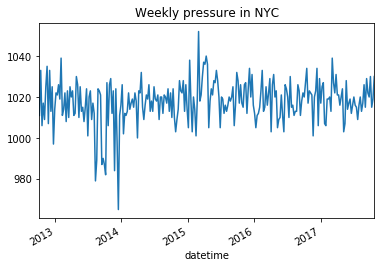

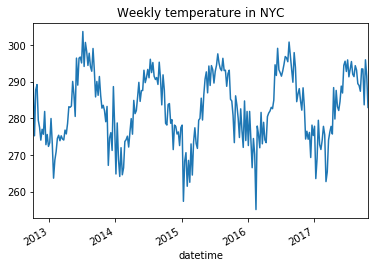

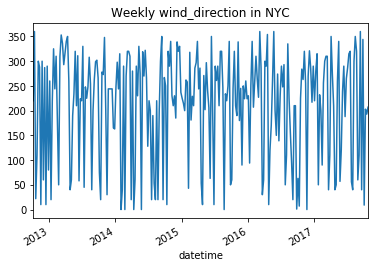

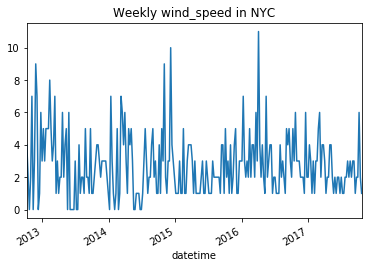

In [14]:
for name in numerical_names:
    plt.figure()
    data[name][NYC][:last_good_reading].asfreq("W").plot()
    plt.title("Weekly %s in NYC" % name)

Even after limiting our data to before 2017-10-28 the tail of our data still looks a bit different. Perhaps the sensors were slowly dieing even before they returned NaNs and maybe we should ignore even more of the data. We should probably try to look at error logs or figure out if anything was going wrong before 2017-10-28. For now, lets pretend it's valid data.

## Splitting our data into training, validation, and test sets

We also notice a large amount of seasonal patterns in our weather data which makes a lot of sense. So we're going to break up our data to have 1-year chunks for our validation and test sets. This should give us about 3 years of data to train on. This is because its likely that the seasonality probably means some parts of the year will be easier to predict than others and so by using a yearly quantization for model evaluation we can ignore these effects.

Also, if this was for a more in depth model development, we would do a sliding 1 year cross validation set (so we would have several training and validation sets) to have more confidence in our results. Or we could try TimeSeriesSplit from sklearn which would be a bit more careful about not overtraining 1 part of the year by enforcing the training set is also quantized by the same amount.

See supplemental for some seasonal trend decomposition visualizations.



In [15]:
data_split_indices = np.array(
    [
        data["humidity"][NYC].dropna().index[0],
        last_good_reading - dt.timedelta(days=365 * 2),
        last_good_reading - dt.timedelta(days=365),
        last_good_reading,
    ]
)

set_labels = ["train", "validation", "test"]

for i, dataset in enumerate(set_labels):
    print(
        "%s set size: " % (dataset), data_split_indices[i + 1] - data_split_indices[i]
    )

train set size:  1122 days 11:00:00
validation set size:  365 days 00:00:00
test set size:  365 days 00:00:00


Now lets take a look at weather_description:

In [16]:
data["weather_description"].fillna(method="ffill", inplace=True)
data["weather_description"].head()

,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,San Antonio,Dallas,Houston,Kansas City,Minneapolis,Saint Louis,Chicago,Nashville,Indianapolis,Atlanta,Detroit,Jacksonville,Charlotte,Miami,Pittsburgh,Toronto,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,haze,NaN,NaN,NaN
2012-10-01 13:00:00,mist,scattered clouds,light rain,sky is clear,mist,sky is clear,sky is clear,sky is clear,sky is clear,light rain,sky is clear,mist,sky is clear,sky is clear,broken clouds,sky is clear,overcast clouds,mist,overcast clouds,light rain,sky is clear,scattered clouds,mist,light intensity drizzle,mist,sky is clear,broken clouds,few clouds,overcast clouds,sky is clear,sky is clear,sky is clear,haze,sky is clear,sky is clear,sky is clear
2012-10-01 14:00:00,broken clouds,scattered clouds,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,broken clouds,sky is clear,sky is clear,sky is clear,sky is clear,broken clouds,sky is clear,overcast clouds,overcast clouds,overcast clouds,overcast clouds,sky is clear,scattered clouds,overcast clouds,broken clouds,scattered clouds,sky is clear,broken clouds,few clouds,sky is clear,few clouds,sky is clear,sky is clear,broken clouds,overcast clouds,sky is clear,overcast clouds
2012-10-01 15:00:00,broken clouds,scattered clouds,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,broken clouds,sky is clear,sky is clear,sky is clear,sky is clear,broken clouds,sky is clear,overcast clouds,overcast clouds,overcast clouds,overcast clouds,sky is clear,scattered clouds,overcast clouds,broken clouds,scattered clouds,sky is clear,broken clouds,few clouds,sky is clear,few clouds,overcast clouds,sky is clear,broken clouds,overcast clouds,overcast clouds,overcast clouds
2012-10-01 16:00:00,broken clouds,scattered clouds,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,broken clouds,sky is clear,sky is clear,sky is clear,sky is clear,broken clouds,sky is clear,overcast clouds,overcast clouds,overcast clouds,overcast clouds,sky is clear,scattered clouds,overcast clouds,broken clouds,scattered clouds,sky is clear,broken clouds,few clouds,sky is clear,few clouds,overcast clouds,sky is clear,broken clouds,overcast clouds,overcast clouds,overcast clouds


We could save a lot of ram if we set all these as categorical data... but its a pretty small dataset so I won't worry for now.

Just for curiosity's sake, lets see what weather patterns NYC misses out on or weather patterns NYC has that other cities don't have...

In [17]:
union = set()

for col in data["weather_description"]:
    union |= set(data["weather_description"][col].unique())

intersection = union.copy()
for col in data["weather_description"]:
    intersection &= set(data["weather_description"][col].unique())

print(union)
print(intersection)

{nan, 'snow', 'light shower sleet', 'thunderstorm with heavy drizzle', 'proximity shower rain', 'smoke', 'heavy shower snow', 'light intensity drizzle', 'light shower snow', 'sand/dust whirls', 'ragged shower rain', 'proximity sand/dust whirls', 'thunderstorm with light drizzle', 'sky is clear', 'sleet', 'overcast clouds', 'proximity moderate rain', 'heavy intensity drizzle', 'thunderstorm', 'heavy intensity rain', 'light intensity drizzle rain', 'rain and snow', 'thunderstorm with light rain', 'shower snow', 'squalls', 'proximity thunderstorm with drizzle', 'heavy intensity shower rain', 'dust', 'haze', 'proximity thunderstorm', 'fog', 'tornado', 'shower rain', 'light rain', 'light snow', 'drizzle', 'proximity thunderstorm with rain', 'freezing rain', 'sand', 'heavy snow', 'scattered clouds', 'shower drizzle', 'thunderstorm with drizzle', 'light rain and snow', 'thunderstorm with heavy rain', 'thunderstorm with rain', 'volcanic ash', 'very heavy rain', 'mist', 'ragged thunderstorm', '

In [18]:
nyc_weather_types = set(data["weather_description"][NYC].unique())
print("nyc's weather types:\n", nyc_weather_types)
print("missing that other cities have:\n", union - nyc_weather_types)
print(
    "special weather that other cities may be missing:\n",
    nyc_weather_types - intersection,
)

nyc's weather types:
 {nan, 'snow', 'thunderstorm with light rain', 'squalls', 'proximity thunderstorm with drizzle', 'smoke', 'dust', 'haze', 'proximity thunderstorm', 'light intensity drizzle', 'fog', 'sand/dust whirls', 'shower rain', 'light rain', 'light snow', 'thunderstorm with light drizzle', 'drizzle', 'proximity thunderstorm with rain', 'sky is clear', 'freezing rain', 'sand', 'heavy snow', 'scattered clouds', 'overcast clouds', 'light rain and snow', 'heavy intensity drizzle', 'thunderstorm with rain', 'thunderstorm with heavy rain', 'thunderstorm', 'very heavy rain', 'mist', 'heavy intensity rain', 'light intensity shower rain', 'few clouds', 'heavy thunderstorm', 'broken clouds', 'moderate rain'}
missing that other cities have:
 {'light shower sleet', 'sleet', 'light intensity drizzle rain', 'heavy shower snow', 'light shower snow', 'rain and snow', 'shower drizzle', 'volcanic ash', 'proximity moderate rain', 'thunderstorm with drizzle', 'tornado', 'thunderstorm with heavy 

Man, look at all those types of precipitation that NYC gets that other cities don't... well lets ignore this for now...

Alright, lets define what rain is for the purpose of this analysis:

N.B. NaN is considered not rain for this analysis, although for now it should just be the leading points which we'll drop anyways.

In [19]:
def is_rain(weather):
    if pd.isnull(weather):
        return False
    for part in ["rain", "storm", "drizzle", "shower"]:
        if part in weather:
            return True
    return False


print("rain weather types:")
print([weather for weather in union if is_rain(weather)])
print("\n\nnot rain types:")
print([weather for weather in union if not is_rain(weather)])

rain weather types:
['light shower sleet', 'thunderstorm with heavy drizzle', 'proximity shower rain', 'heavy shower snow', 'light intensity drizzle', 'light shower snow', 'ragged shower rain', 'thunderstorm with light drizzle', 'proximity moderate rain', 'heavy intensity drizzle', 'thunderstorm', 'heavy intensity rain', 'light intensity drizzle rain', 'rain and snow', 'thunderstorm with light rain', 'shower snow', 'proximity thunderstorm with drizzle', 'heavy intensity shower rain', 'proximity thunderstorm', 'shower rain', 'light rain', 'drizzle', 'proximity thunderstorm with rain', 'freezing rain', 'shower drizzle', 'thunderstorm with drizzle', 'light rain and snow', 'thunderstorm with heavy rain', 'thunderstorm with rain', 'very heavy rain', 'ragged thunderstorm', 'light intensity shower rain', 'heavy thunderstorm', 'moderate rain']


not rain types:
[nan, 'snow', 'smoke', 'sand/dust whirls', 'proximity sand/dust whirls', 'sky is clear', 'sleet', 'overcast clouds', 'squalls', 'dust'

In [ ]:
data["rain"] = data["weather_description"].applymap(is_rain)

Lets look at Autocorrelation and Partial Autocorrelation of whether its raining for a bit:

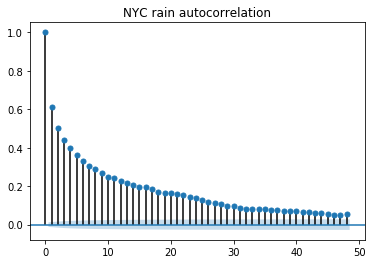

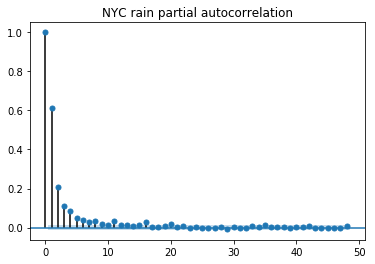

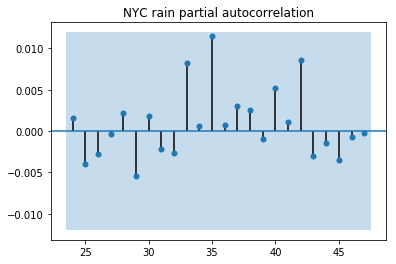

In [21]:
f = plot_acf(
    data["rain"][NYC][data_split_indices[0] : data_split_indices[1]],
    lags=48,
    title="NYC rain autocorrelation",
)
f = plot_pacf(
    data["rain"][NYC][data_split_indices[0] : data_split_indices[1]],
    lags=48,
    title="NYC rain partial autocorrelation",
)
f = plot_pacf(
    data["rain"][NYC][data_split_indices[0] : data_split_indices[1]],
    lags=np.arange(24, 48),
    title="NYC rain partial autocorrelation",
)

Thats not particularly good... We have no significant coefficients >24 hours in advance.

If we compare it to rhat of humidity:

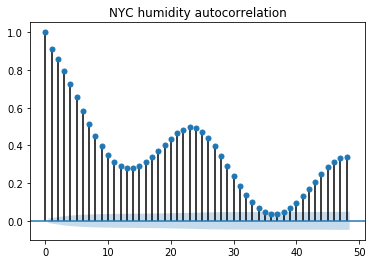

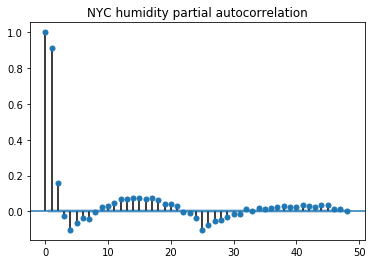

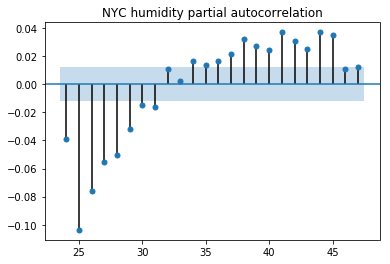

In [22]:
f = plot_acf(
    data["humidity"][NYC][data_split_indices[0] : data_split_indices[1]],
    lags=48,
    title="NYC humidity autocorrelation",
)
f = plot_pacf(
    data["humidity"][NYC][data_split_indices[0] : data_split_indices[1]],
    lags=48,
    title="NYC humidity partial autocorrelation",
)
f = plot_pacf(
    data["humidity"][NYC][data_split_indices[0] : data_split_indices[1]],
    lags=np.arange(24, 48),
    title="NYC humidity partial autocorrelation",
)

So there is predictable information out at that timescale, we just may have to use more than just whether its raining for the prediction.

## Generating Labels

Now lets generate labels (keeping our data sets separate of course)

We're going to define our task as:

Given the current sensor data, can we predict whether there will be liquid precipitation in the next 24 hours.

Note, rolling labels the interval by the end so we subtract off the interval to get whether it will rain in the next day

In [ ]:
def _rain_next_day(data):
    start = data.index[0]
    out = data.rolling("1d").apply(np.any, raw=True)
    out.index -= dt.timedelta(days=1)
    return out[start:]


rain_next_day = {
    dataset: _rain_next_day(
        data["rain"][NYC][data_split_indices[i] : data_split_indices[i + 1]]
    )
    for i, dataset in enumerate(set_labels)
}

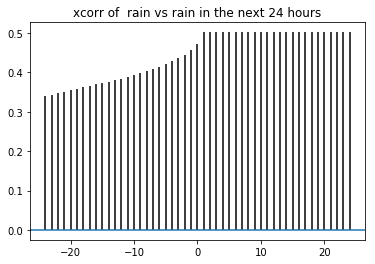

In [24]:
y = rain_next_day["train"].astype(float)
x = data["rain"][NYC][y.index].astype(float)

_ = plt.xcorr(x, y, maxlags=24)
_ = plt.title("xcorr of  rain vs rain in the next 24 hours")

Alright, lets start doing some predictions shall we.

To start, lets just use a logistic regression.
We'll start by simply using the current, boolean value of rain to predict whether there will be rain in the next 24 hours.

We'll also set up the parameter gridsearch just to set up the infrastructure, even though for this simple model it won't likely help.

In [25]:
y = rain_next_day["train"].astype(float)
x = data["rain"][NYC][y.index].astype(float)

y_val = rain_next_day["validation"].astype(float)
x_val = data["rain"][NYC][y_val.index].astype(float)

x = x.values.reshape(-1, 1)
y = y.values
x_val = x_val.values.reshape(-1, 1)
y_val = y_val.values

scaler = StandardScaler().fit(x)

param_grid = [
    {
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "penalty": ["elasticnet"],
        "solver": ["saga"],
        "l1_ratio": [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
    }
]

gs = GridSearch(model=LogisticRegression(), param_grid=param_grid)
gs.fit(scaler.transform(x), y, scaler.transform(x_val), y_val, scoring="roc_auc")

default = LogisticRegression(solver="saga")
_ = default.fit(scaler.transform(x), y)
print("model scores:")
print(
    default.score(scaler.transform(x_val), y_val),
    gs.score(scaler.transform(x_val), y_val),
)

100%|██████████| 42/42 [00:01<00:00, 24.38it/s]


model scores:
0.6370607760100722 0.6370607760100722


This provides a strawman baseline to compare other models against: a score of 0.637

Now lets see if we can do better using current data from humidity, pressure, temperature, wind_direction, and wind_speed

In [26]:
y = rain_next_day["train"].astype(float)
x = np.zeros((len(y), len(numerical_names) + 1))

y_val = rain_next_day["validation"].astype(float)
x_val = np.zeros((len(y_val), len(numerical_names) + 1))

for i, name in enumerate(numerical_names):
    x[:, i] = data[name][NYC][y.index].values
    x_val[:, i] = data[name][NYC][y_val.index].values
x[:, -1] = data["rain"][NYC][y.index].astype(float).values
x_val[:, -1] = data["rain"][NYC][y_val.index].astype(float).values

y = y.values
y_val = y_val.values

scaler = StandardScaler().fit(x)

param_grid = [
    {
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "penalty": ["elasticnet"],
        "solver": ["saga"],
        "l1_ratio": [0, 0.1, 0.3, 0.5, 0.7, 0.9, 1],
    }
]

gs = GridSearch(model=LogisticRegression(), param_grid=param_grid)
gs.fit(scaler.transform(x), y, scaler.transform(x_val), y_val, scoring="roc_auc")

default = LogisticRegression(solver="saga")
_ = default.fit(scaler.transform(x), y)
print("\nmodel scores:")
print("non-optimized: ", default.score(scaler.transform(x_val), y_val))
print("optimized: ", gs.score(scaler.transform(x_val), y_val))
print(gs.model)

100%|██████████| 42/42 [00:04<00:00,  9.67it/s]



model scores:
non-optimized:  0.7004692686276754
optimized:  0.7013849147304567
LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='elasticnet',
                   random_state=0, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


So, we've boosted our score up to 0.701 and our grid search provided a tiny improvement. How about XGBoost?

In [27]:
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic", random_state=42, eval_metric="auc"
)
xgb_model.fit(scaler.transform(x), y, eval_set=[(scaler.transform(x_val), y_val)])
roc_auc_score(y_val, xgb_model.predict_proba(scaler.transform(x_val))[:, 1])

[0]	validation_0-auc:0.722113
[1]	validation_0-auc:0.744393
[2]	validation_0-auc:0.756032
[3]	validation_0-auc:0.757153
[4]	validation_0-auc:0.757143
[5]	validation_0-auc:0.762287
[6]	validation_0-auc:0.761911
[7]	validation_0-auc:0.762902
[8]	validation_0-auc:0.766512
[9]	validation_0-auc:0.76682
[10]	validation_0-auc:0.764669
[11]	validation_0-auc:0.767294
[12]	validation_0-auc:0.767801
[13]	validation_0-auc:0.765753
[14]	validation_0-auc:0.765699
[15]	validation_0-auc:0.766015
[16]	validation_0-auc:0.768364
[17]	validation_0-auc:0.76778
[18]	validation_0-auc:0.768603
[19]	validation_0-auc:0.76986
[20]	validation_0-auc:0.770339
[21]	validation_0-auc:0.770682
[22]	validation_0-auc:0.773953
[23]	validation_0-auc:0.773798
[24]	validation_0-auc:0.774104
[25]	validation_0-auc:0.774988
[26]	validation_0-auc:0.775745
[27]	validation_0-auc:0.775856
[28]	validation_0-auc:0.776559
[29]	validation_0-auc:0.776698
[30]	validation_0-auc:0.777767
[31]	validation_0-auc:0.778491
[32]	validation_0-auc

0.7877273129543894

Thats another solid jump of our score to 0.7877 using a deep learning method.

Lets look at the feature importance in the model

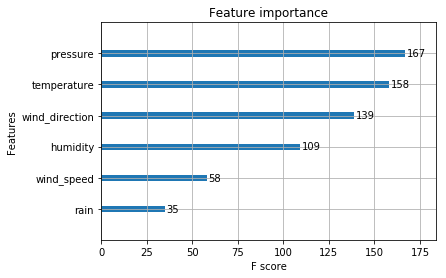

In [28]:
xgb_model.get_booster().feature_names = numerical_names + ["rain"]
_ = xgb.plot_importance(
    xgb_model,
)

Humidity isn't as high as I expected, and wind_speed and rain have a pretty low F score which is what we expected from our partial correlation analysis.

## Time lags

Here lets use time lags to see if adding information about the recent history improves our history much.

In [29]:
for num_lags in range(1, 13):
    lagged_x = lagmat(x, lags=range(num_lags + 1))[num_lags:]
    lagged_y = y[num_lags:]

    lagged_x_val = lagmat(x_val, lags=range(num_lags + 1))[num_lags:]
    lagged_y_val = y_val[num_lags:]

    scaler = StandardScaler().fit(lagged_x)

    xgb_model = xgb.XGBClassifier(
        objective="binary:logistic", random_state=42, eval_metric="auc"
    )
    xgb_model.fit(scaler.transform(lagged_x), lagged_y)
    score = roc_auc_score(
        lagged_y_val, xgb_model.predict_proba(scaler.transform(lagged_x_val))[:, 1]
    )
    print(num_lags, score)

1 0.7979152659022708
2 0.8033464158131485
3 0.8041644536907111
4 0.8032613294406303
5 0.8039436016847292
6 0.8054095512615451
7 0.8044627940894241
8 0.8024771938568411
9 0.8046494666353636
10 0.8074359538464926
11 0.8075407729987758
12 0.8078709910108794


A bit, but not that much unfortunately... an LSTM may be useful, but it doesn't look like there is much relevant information beyond what the current sensors show.

# Exponentially weighted filtering

Lets try a bit of exponential filtering on the data points could help. I'm going to use a single filter for all the input dimensions, but for a more in depth analysis I would check to see if each dimension had a different optimal filtering parameter.

I'm also just doing a hand tuned grid search here, but ideally I'd like to use some sort bayesian hyperperameter optimization here, but for proof of concept I think this is fine.

In [63]:
alphas = [0.1, 0.3, 0.5, 0.7, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.85, 0.9]
scores = np.zeros_like(alphas)

for score_index, alpha in enumerate(alphas):
    y = rain_next_day["train"].astype(float)
    x = np.zeros((len(y), len(numerical_names) + 1))

    y_val = rain_next_day["validation"].astype(float)
    x_val = np.zeros((len(y_val), len(numerical_names) + 1))

    for i, name in enumerate(numerical_names):
        x[:, i] = data[name][NYC].ewm(alpha=alpha).mean()[y.index].values
        x_val[:, i] = data[name][NYC].ewm(alpha=alpha).mean()[y_val.index].values
    x[:, -1] = data["rain"][NYC].ewm(alpha=alpha).mean()[y.index].astype(float).values
    x_val[:, -1] = (
        data["rain"][NYC].ewm(alpha=alpha).mean()[y_val.index].astype(float).values
    )

    y = y.values
    y_val = y_val.values

    scaler = StandardScaler().fit(x)

    xgb_model = xgb.XGBClassifier(
        objective="binary:logistic", random_state=42, eval_metric="auc"
    )
    xgb_model.fit(scaler.transform(x), y)
    scores[score_index] = roc_auc_score(
        y_val, xgb_model.predict_proba(scaler.transform(x_val))[:, 1]
    )
    print(alpha, scores[score_index])

0.1 0.7858474884624663
0.3 0.7948880513338803
0.5 0.7964905070237113
0.7 0.8075331055005427
0.75 0.8093708048358207
0.76 0.7790505221989661
0.77 0.8080059724236883
0.78 0.8074619998225474
0.79 0.8101308423796186
0.8 0.8094413439347083
0.85 0.8079104755151139
0.9 0.5


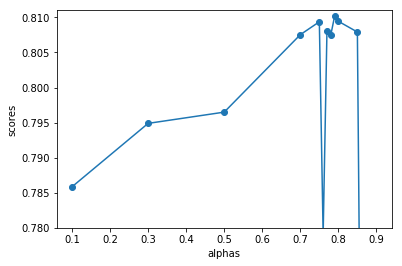

In [61]:
_ = plt.plot(alphas, scores, "-o")
_ = plt.xlabel("alphas")
_ = plt.ylabel("scores")
_ = plt.ylim((0.78, 0.811))

This once shows promise but once again we can definitely see fluctuations in our score which probably indicates that we're overfitting to the validation set.

Lets see if the exp filtered data + current time points do even better:
(ARIMA inspired)

In [70]:
alphas_concat = [
    0.1,
    0.3,
    0.5,
    0.6,
    0.65,
    0.66,
    0.67,
    0.68,
    0.69,
    0.7,
    0.71,
    0.72,
    0.73,
    0.74,
    0.75,
    0.76,
    0.77,
    0.78,
    0.79,
    0.8,
    0.85,
    0.9,
]
scores_concat = np.zeros_like(alphas_concat)

for score_index, alpha in enumerate(alphas_concat):
    y = rain_next_day["train"].astype(float)
    x = np.zeros((len(y), 2 * len(numerical_names) + 1))

    y_val = rain_next_day["validation"].astype(float)
    x_val = np.zeros((len(y_val), 2 * len(numerical_names) + 1))

    for i, name in enumerate(numerical_names):
        x[:, i] = data[name][NYC][y.index].values
        x_val[:, i] = data[name][NYC][y_val.index].values
        x[:, len(numerical_names) + i] = (
            data[name][NYC].ewm(alpha=alpha).mean()[y.index].values
        )
        x_val[:, len(numerical_names) + i] = (
            data[name][NYC].ewm(alpha=alpha).mean()[y_val.index].values
        )
    x[:, -1] = data["rain"][NYC].ewm(alpha=alpha).mean()[y.index].astype(float).values
    x_val[:, -1] = (
        data["rain"][NYC].ewm(alpha=alpha).mean()[y_val.index].astype(float).values
    )

    y = y.values
    y_val = y_val.values

    scaler = StandardScaler().fit(x)

    xgb_model = xgb.XGBClassifier(
        objective="binary:logistic", random_state=42, eval_metric="auc"
    )
    xgb_model.fit(scaler.transform(x), y)
    scores_concat[score_index] = roc_auc_score(
        y_val, xgb_model.predict_proba(scaler.transform(x_val))[:, 1]
    )
    print(alpha, scores_concat[score_index])

0.1 0.8054719473652543
0.3 0.7986554907804548
0.5 0.797330347234805
0.6 0.7974447112276601
0.65 0.7840221405517325
0.66 0.8124976132855095
0.67 0.7835069784982095
0.68 0.7837595877933022
0.69 0.781382476818699
0.7 0.8108052698202686
0.71 0.8100706150204882
0.72 0.8106282988360313
0.73 0.8109780764480656
0.74 0.8111174832374739
0.75 0.8105247565041298
0.76 0.7788589901316652
0.77 0.8103716385003196
0.78 0.8094542902673154
0.79 0.8105826325599642
0.8 0.8100522011994933
0.85 0.8097963340745321
0.9 0.5


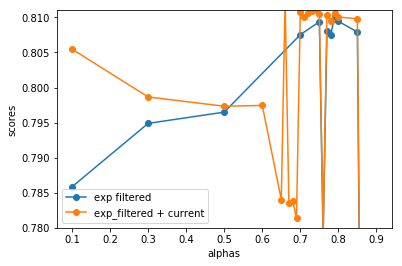

In [72]:
_ = plt.plot(alphas, scores, "-o", label="exp filtered")
_ = plt.plot(alphas_concat, scores_concat, "-o", label="exp_filtered + current")
_ = plt.xlabel("alphas")
_ = plt.ylabel("scores")
_ = plt.ylim((0.78, 0.811))
_ = plt.legend()

This representation is higher dimensional so there is definitely more overfitting occuring here, but there seems to be a region where the newer performance is consistently higher.

## Cyclical hour encoding

Perhaps time of day could help our predictions. A certain pressure and temp might mean one thing at mid-day but a completely different thing at mid-night.

We'll encode our model cyclically using 2 dimensions. This could cause issues with our xgboost model since it only splits on a single dimension so lets try differnt offsets to hopefully align one of the features to whatever pattern is most relevant for the prediction.

We only need to offsets up to a 1/4th the period (6 hours)

In [207]:
for offset in range(6):
    y = rain_next_day["train"].astype(float)
    x = np.zeros((len(y), len(numerical_names) + 1 + 2))

    y_val = rain_next_day["validation"].astype(float)
    x_val = np.zeros((len(y_val), len(numerical_names) + 1 + 2))

    for i, name in enumerate(numerical_names):
        x[:, i] = data[name][NYC][y.index].values
        x_val[:, i] = data[name][NYC][y_val.index].values
    x[:, -1] = data["rain"][NYC][y.index].astype(float).values
    x_val[:, -1] = data["rain"][NYC][y_val.index].astype(float).values

    x[:, -2] = np.sin(2 * np.pi * (y.index.hour.values + offset) / 24)
    x[:, -3] = np.cos(2 * np.pi * (y.index.hour.values + offset) / 24)
    x_val[:, -2] = np.sin(2 * np.pi * (y_val.index.hour.values + offset) / 24)
    x_val[:, -3] = np.cos(2 * np.pi * (y_val.index.hour.values + offset) / 24)

    y = y.values
    y_val = y_val.values

    scaler = StandardScaler().fit(x)

    xgb_model = xgb.XGBClassifier(
        objective="binary:logistic", random_state=42, eval_metric="auc"
    )
    xgb_model.fit(scaler.transform(x), y)
    print(
        offset,
        roc_auc_score(y_val, xgb_model.predict_proba(scaler.transform(x_val))[:, 1]),
    )

0 0.7864439829468753
1 0.7871945019616668
2 0.7853205982214175
3 0.7871418667625771
4 0.7883947998009722
5 0.7880680253007034


Once again, only minor improvement at the best offset (0.7884) compared to 0.7877 and we can't be sure it isn't just overfitting on the validation set. Once again, a more serious exploration would probably use more cross validation to try to mitigate that possibility.

Should we try over a yearly cycle?

In [208]:
for offset in range(3):  # months
    y = rain_next_day["train"].astype(float)
    x = np.zeros((len(y), len(numerical_names) + 1 + 2))

    y_val = rain_next_day["validation"].astype(float)
    x_val = np.zeros((len(y_val), len(numerical_names) + 1 + 2))

    for i, name in enumerate(numerical_names):
        x[:, i] = data[name][NYC][y.index].values
        x_val[:, i] = data[name][NYC][y_val.index].values
    x[:, -1] = data["rain"][NYC][y.index].astype(float).values
    x_val[:, -1] = data["rain"][NYC][y_val.index].astype(float).values

    x[:, -2] = np.sin(
        2
        * np.pi
        * (y.index.dayofyear * 24 + y.index.hour.values + offset * 24 * 30)
        / (24 * 365)
    )
    x[:, -3] = np.cos(
        2
        * np.pi
        * (y.index.dayofyear * 24 + y.index.hour.values + offset * 24 * 30)
        / (24 * 365)
    )
    x_val[:, -2] = np.sin(
        2
        * np.pi
        * (y_val.index.dayofyear * 24 + y_val.index.hour.values + offset * 24 * 30)
        / (24 * 365)
    )
    x_val[:, -3] = np.cos(
        2
        * np.pi
        * (y_val.index.dayofyear * 24 + y_val.index.hour.values + offset * 24 * 30)
        / (24 * 365)
    )

    y = y.values
    y_val = y_val.values

    scaler = StandardScaler().fit(x)

    xgb_model = xgb.XGBClassifier(
        objective="binary:logistic", random_state=42, eval_metric="auc"
    )
    xgb_model.fit(scaler.transform(x), y)
    print(
        offset,
        roc_auc_score(y_val, xgb_model.predict_proba(scaler.transform(x_val))[:, 1]),
    )

0 0.7805647331927991
1 0.758744100353398
2 0.7794024244826537


And this definitely made it worse...

Its likely that the seasonal cycles already inherent in our data already contained all the relevant predictive information from time. Also, this kind of encoding is hard on our XGBoost since it only gets to make a decision based on a single dimension at once.

# Final Score

W're just going to use the concatenated exponential filtered data.

We're going to use alpha of .79 because it was the highest in the exponential filtered data alone and because it was in the center of the region where the concatenated data was consistently higher than the exponential filtered data alone. Even though alpha=.7 had a higher score, it was right at the edge of the consistent region and I wanted to stay away from the high score variability region.

In [77]:
alpha = 0.79

y = rain_next_day["train"].astype(float)
x = np.zeros((len(y), 2 * len(numerical_names) + 1))

y_val = rain_next_day["validation"].astype(float)
x_val = np.zeros((len(y_val), 2 * len(numerical_names) + 1))

y_test = rain_next_day["test"].astype(float)
x_test = np.zeros((len(y_test), 2 * len(numerical_names) + 1))

for i, name in enumerate(numerical_names):
    x[:, i] = data[name][NYC][y.index].values
    x_val[:, i] = data[name][NYC][y_val.index].values
    x_test[:, i] = data[name][NYC][y_test.index].values
    x[:, len(numerical_names) + i] = (
        data[name][NYC].ewm(alpha=alpha).mean()[y.index].values
    )
    x_val[:, len(numerical_names) + i] = (
        data[name][NYC].ewm(alpha=alpha).mean()[y_val.index].values
    )
    x_test[:, len(numerical_names) + i] = (
        data[name][NYC].ewm(alpha=alpha).mean()[y_test.index].values
    )
x[:, -1] = data["rain"][NYC].ewm(alpha=alpha).mean()[y.index].astype(float).values
x_val[:, -1] = (
    data["rain"][NYC].ewm(alpha=alpha).mean()[y_val.index].astype(float).values
)
x_test[:, -1] = (
    data["rain"][NYC].ewm(alpha=alpha).mean()[y_test.index].astype(float).values
)

y = y.values
y_val = y_val.values
y_test = y_test.values

scaler = StandardScaler().fit(x)

xgb_model = xgb.XGBClassifier(
    objective="binary:logistic", random_state=42, eval_metric="auc"
)
xgb_model.fit(scaler.transform(x), y)
score = roc_auc_score(y_test, xgb_model.predict_proba(scaler.transform(x_test))[:, 1])
print("final score: ", score)

final score:  0.7834815927402453


This score is lower than even the first xgboost model we ran. This is probably because we were overfitting the validation set because we didn't do a full cross validation scheme. And also this is probably because of the strangeness we saw near the end of our data. Whether it was because of sensor malfunction or climate change, the data in the most recent year behaved differently than it did previously which probably contributed to our reduction in score.

## Things I would have liked to try had I more time
Full cross validation

vary the alpha for exp filtering for each data channel and use an adaptive hyper-parameter optimizaion technique.

LSTM prediction

Contrastive Predictive Coding for unsupervised feature extraction to combine the feature data

UMAP projection of current features colored by rain or by full weather description titles

Embedding the full weather description titles to see if an unsupervised embedding of the full titles would improve the performance

Tansfer learning from other cities' data.

Does Philadelphia's sensor data help predict NYC's weather?

# Supplemental

## Geography Lesson

Lets check to see what cities we have that are near NYC:

In [78]:
lat, long = data["city_attributes"].loc[NYC, ["Latitude", "Longitude"]]


def dist2NYC(row):
    return geopy.distance.distance(
        (row["Latitude"], row["Longitude"]), (lat, long)
    ).miles


data["city_attributes"].apply(dist2NYC, axis=1).sort_values()

City
New York                0.000000
Philadelphia           80.629596
Boston                190.277624
Pittsburgh            315.643105
Montreal              331.648300
Toronto               345.628686
Detroit               481.679470
Charlotte             531.235405
Indianapolis          645.311008
Chicago               713.795771
Atlanta               746.333851
Nashville             759.915214
Jacksonville          834.752213
Saint Louis           873.896527
Minneapolis          1018.688984
Miami                1089.405894
Kansas City          1096.216144
Dallas               1373.108614
Houston              1418.539016
San Antonio          1583.233014
Denver               1631.193785
Albuquerque          1814.795621
Phoenix              2144.321095
Las Vegas            2232.464459
Seattle              2408.146743
Vancouver            2432.420814
San Diego            2432.689254
Portland             2445.427316
Los Angeles          2450.943755
San Francisco        2571.927166
Nahar

I wonder if Philadelphia sensor data would have information that could help predict the weather in NYC? We can take a look at that after we explore auto-predictive information.

## Seasonal Decomposition

Decompose daily trend


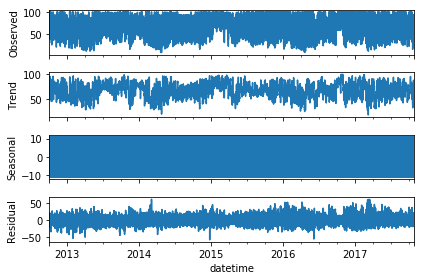

In [24]:
print("Decompose daily trend")
f = sm.tsa.seasonal_decompose(
    data["humidity"][NYC][:last_good_reading].dropna(), freq=24
).plot()

Decompose weekly trend


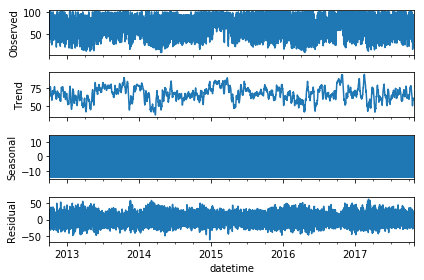

In [25]:
print("Decompose weekly trend")
f = sm.tsa.seasonal_decompose(
    data["humidity"][NYC][:last_good_reading].dropna(), freq=24 * 7
).plot()

Decompose yearly trend


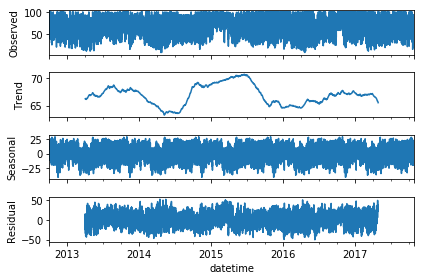

In [26]:
print("Decompose yearly trend")
f = sm.tsa.seasonal_decompose(
    data["humidity"][NYC][:last_good_reading].dropna(), freq=24 * 365
).plot()